# Learned Tuner Evaluation

In [63]:
from copy import deepcopy
import os
import pathlib
import sys
import sqlite3

if '../' not in sys.path:
    sys.path.append('../')

In [64]:
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [65]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy.stats as stats
import toml
import torch
import torchinfo
import polars as pl

In [66]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [67]:
from axe.lsm.cost import Cost
from axe.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from axe.lcm.data.schema import LCMDataSchema, kWORKLOAD_HEADER, kSYSTEM_HEADER
from axe.ltuner.data.schema import LTunerDataSchema
from experiments.evaluate_ltuner import LTunerEvaluator

# Data Loading

Either run the experiment in the notebook, or load from a previous DB

In [68]:
model_path = "../data/ltuner/models/kaplsm_250514_1230/"
config = toml.load(os.path.join(model_path, "axe.toml"))
policy = getattr(Policy, config['lsm']['policy'])
bounds = LSMBounds(**config['lsm']['bounds'])
ltune_schema = LTunerDataSchema(policy=policy, bounds=bounds)
lcm_schema = LCMDataSchema(policy=policy, bounds=bounds)

# evaluator = LTunerEvaluator(config, model_path=model_path, model_name="checkpoints/epoch01.model")
evaluator = LTunerEvaluator(config, model_path=model_path, model_name="best_model.model")

In [69]:
# connection = sqlite3.connect("../data/axe_data.db")
# input_table = pl.read_database("SELECT * FROM environments;", connection)
input_table = evaluator.generate_test_data(num_samples=10000)
input_table

Test Data: 100%|███████████████████████| 10000/10000 [00:00<00:00, 58277.61it/s]


empty_reads,non_empty_reads,range_queries,writes,entries_per_page,selectivity,entry_size,mem_budget,num_entries,rho
f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
0.225,0.432,0.166,0.177,32.0,8.8916e-8,4096,8.885327,47603495,0.41211
0.202,0.632,0.014,0.152,16.0,9.9417e-8,2048,7.143432,97106755,1.403502
0.058,0.153,0.785,0.004,16.0,9.1892e-8,8192,7.835144,25518459,0.64588
0.012,0.137,0.444,0.407,8.0,6.6010e-8,8192,10.21515,32483219,0.141778
0.555,0.0,0.43,0.015,32.0,1.7939e-8,1024,16.300663,44707434,0.867578
…,…,…,…,…,…,…,…,…,…
0.25,0.065,0.363,0.322,128.0,6.2638e-9,1024,17.283018,36267436,1.567404
0.373,0.099,0.364,0.164,16.0,3.5838e-8,2048,13.021273,68643534,0.768989
0.122,0.71,0.168,0.0,128.0,3.6617e-8,1024,5.487384,12643344,1.103668


In [70]:
table = evaluator.evaluate(input_table)

Eval:  23%|███████▏                       | 2336/10000 [00:07<00:25, 305.82it/s]/home/ndhuynh/miniconda3/envs/axe/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
Eval: 100%|██████████████████████████████| 10000/10000 [00:33<00:00, 297.24it/s]


In [71]:
table = table.with_columns(delta_cost=((pl.col('cost_solver') - pl.col('cost')) / pl.col('cost_solver')))

In [72]:
table.select(('cost', 'cost_solver', 'delta_cost'))

cost,cost_solver,delta_cost
f64,f64,f64
1.231363,1.117586,-0.101806
0.952911,0.929046,-0.025687
2.185847,2.157378,-0.013196
3.488957,3.060823,-0.139875
0.799081,0.713603,-0.119784
…,…,…
0.783407,0.698908,-0.120902
1.252423,1.24947,-0.002363
1.096433,1.087026,-0.008654


# Training Loss

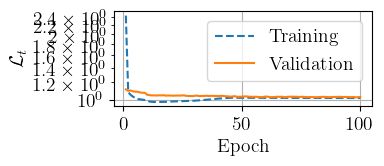

In [73]:
losses = pl.read_csv(os.path.join(model_path, 'losses.csv'))

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.6*height))
ax.plot(losses['epoch'], losses['train_loss'], '--', label='Training')
ax.plot(losses['epoch'], losses['test_loss'], '-', label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$\mathcal{L}_t$')
ax.set_yscale('log')
# ax.set_yticks([1e6, 1e3, 1e0])
# ax.set_ylim([1e0, 1e6])
ax.grid()
_ = ax.legend()
# save_fig(fig, 'ltune_loss.pdf')

## Analytical Cost Model

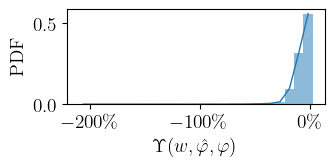

In [74]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.6*height))

data = table['delta_cost']
# hist, bins, _ = ax.hist(data, bins=25, weights=np.ones_like(data)/len(data), alpha=0.5, density=False, color='tab:blue', range=(-0.5, 0.5))
hist, bins, _ = ax.hist(data, bins=25, weights=np.ones_like(data)/len(data), alpha=0.5, density=False, color='tab:blue')
# hist, _, _ = ax.hist(data, bins=20, alpha=1, density=True, color='tab:blue', range=(-0.5, 0.5))
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, linewidth=1)

ax.set_ylabel('PDF')
ax.set_xlabel(r'$\Upsilon(w, \hat{\varphi}, \varphi)$')
# ax.vlines(x=0, ymin=0, ymax=hist.max()+0.05, color='black', linestyles='dashed', linewidth=0.8)
# ax.set_xlim([-0.5, 0.5])
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.show()
# save_fig(fig, 'ltuner_performance.pdf')

Performance values within 10% performance band

In [75]:
table.filter(pl.col('delta_cost') > -0.1).shape[0] / table.shape[0]

0.7396

Positive Performance Values

In [76]:
table.filter(pl.col('delta_cost') > 1).shape[0] / table.shape[0]

0.0

## Learned Cost Model

## Workload Correlations

In [77]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads', labelpad=-30)
    ax.set_ylabel('Range-Reads', labelpad=-30)
    ax.set_zlabel('Writes', labelpad=-30)

    sc = ax.scatter(
        table['empty_reads'] + table['non_empty_reads'],
        table['range_queries'],
        table['writes'],
        c=table[trend],
        cmap='viridis'
    )
    cbar = plt.colorbar(sc, pad=0.05, shrink=0.6)
    cbar.set_label(trend)
    # cbar.ax.tick_params(labelsize=12)
    # font = {'size': 12}
    # ax.tick_params('x', labelsize=font['size'])
    # ax.tick_params('y', labelsize=font['size'])
    # ax.tick_params('z', labelsize=font['size'])
    
    return fig, ax, sc, cbar

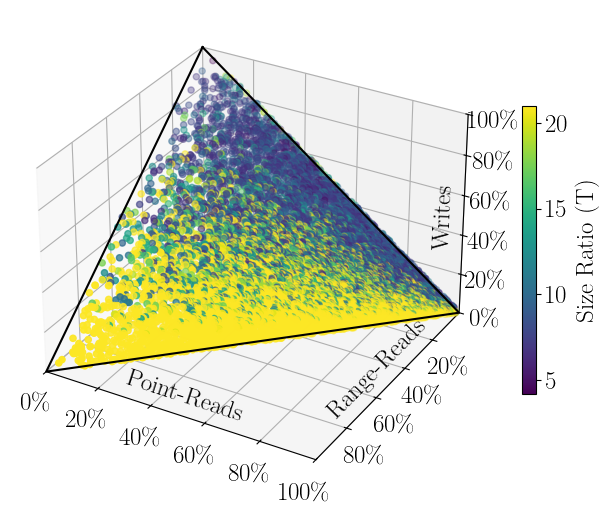

In [78]:
plt.rcParams.update({'font.size': 18})
fig, ax, sc, cbar = plot_workload_trend(table, trend='size_ratio_solver')
cbar.set_label('Size Ratio (T)')
# sc.set_clim([2, 30])
plt.show()
# save_fig(fig, 'analytical_tuner_size_ratio.pdf')

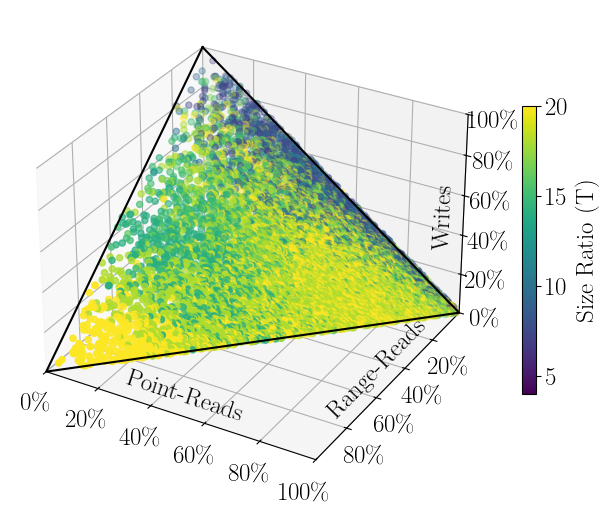

In [79]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='size_ratio')
cbar.set_label('Size Ratio (T)')
# plt.suptitle('AXE: Learned Tuner', x=0.4)
# sc.set_clim([2, 30])
plt.show()
# save_fig(fig, 'learned_tuner_size_ratio.pdf')

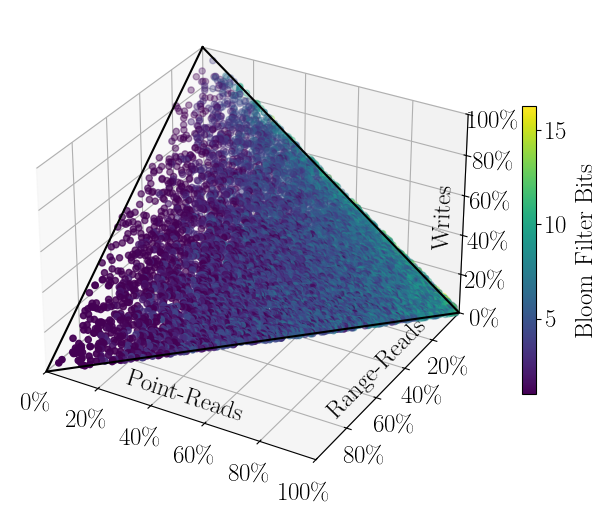

In [80]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='bits_per_elem_solver')
cbar.set_label('Bloom Filter Bits')
# sc.set_clim([1, 15])
plt.show()
# save_fig(fig, 'analytical_tuner_bf.pdf')

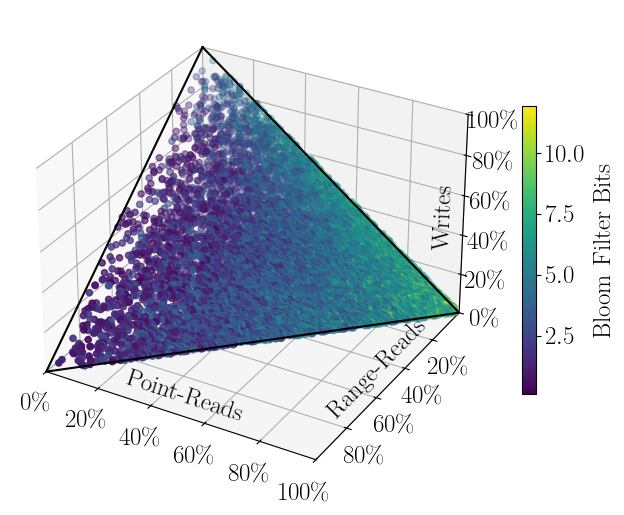

In [81]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='bits_per_elem')
cbar.set_label('Bloom Filter Bits')
# sc.set_clim([1, 15])
plt.show()
# save_fig(fig, 'learned_tuner_bf.pdf')

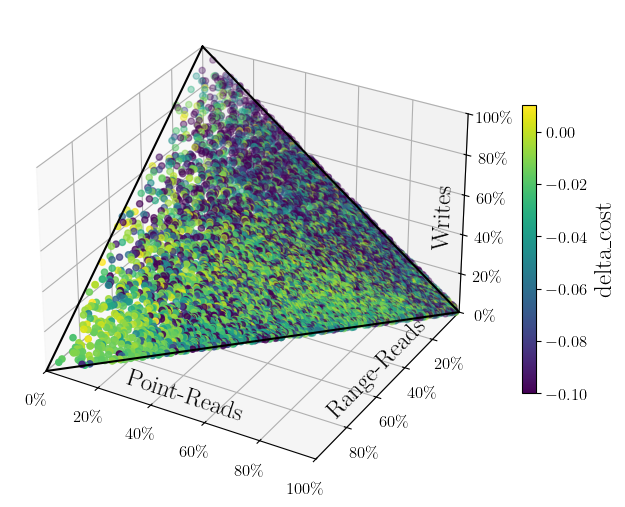

In [82]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

sc = ax.scatter(
    table['empty_reads'] + table['non_empty_reads'],
    table['range_queries'],
    table['writes'],
    c=table['delta_cost'],
    cmap='viridis',
    rasterized=True,
    vmin=-0.1, vmax=0.01
)
cbar = plt.colorbar(sc, pad=0.05, shrink=0.6)
cbar.set_label('delta_cost')
cbar.ax.tick_params(labelsize=12)
font = {'size': 12}
ax.tick_params('x', labelsize=font['size'])
ax.tick_params('y', labelsize=font['size'])
ax.tick_params('z', labelsize=font['size'])

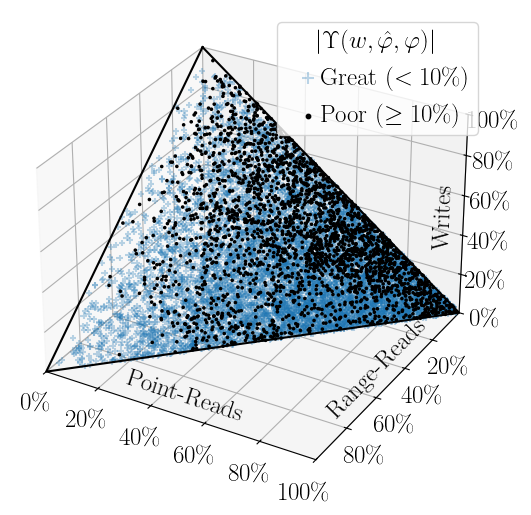

In [83]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

cutoff = (0.1)
groupa = table.filter(pl.col('delta_cost') > -cutoff)
groupb = table.filter(pl.col('delta_cost') < -cutoff)
sc = ax.scatter(
    groupa['empty_reads'] + groupa['non_empty_reads'],
    groupa['range_queries'],
    groupa['writes'],
    label=f'Great $(< {cutoff*100:.0f}\\%)$',
    alpha=0.3, marker='+', color='tab:blue', rasterized=True
)
sc = ax.scatter(
    groupb['empty_reads'] + groupb['non_empty_reads'],
    groupb['range_queries'],
    groupb['writes'],
    label=f'Poor $(\\ge {cutoff*100:.0f}\\%)$',
    alpha=1, marker='.', color='black', rasterized=True, s=10
)
ax.legend(loc='upper right', markerscale=2, title=r'$|\Upsilon(w, \hat{\varphi}, \varphi)|$', handletextpad=-0.5, borderpad=0.25)
plt.show()
# save_fig(fig, 'ltuner_performance_cutoff.pdf')

In [84]:
def gen_table_with_init(num_samples=5000, solver_nominal_kwargs = {'init_args': np.array([3, 3, 1])}):
    np.random.seed(2169)
    num_samples = 5000
    table = []
    for _ in tqdm(range(num_samples)):
        row = ltune_util.gen_sample_eval(solver_nominal_kwargs=solver_nominal_kwargs)
        table.append(row)
    
    table = pd.DataFrame(table)
    table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
    table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
    table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
    table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']
    table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

    return table

In [85]:
best_table = gen_table_with_init()
decent_table = gen_table_with_init(solver_nominal_kwargs={'init_args': np.array([5, 10, 9])})
bad_table = gen_table_with_init(solver_nominal_kwargs={'init_args': np.array([10, 30, 29])})

  0%|          | 0/5000 [00:00<?, ?it/s]

NameError: name 'ltune_util' is not defined

In [ ]:
bad_table['stune_cost']

In [ ]:
bad_table['stune_cost'].loc[2], best_table['stune_cost'].loc[2]

In [ ]:
normed_data = {}
for label, table in (('Boundary', bad_table), ('Random', decent_table)):
    normed_data[label] = (best_table['stune_cost'] - table['stune_cost']) /  best_table['stune_cost']

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*width, 0.8*height), constrained_layout=True)
colors = ('tab:orange', 'tab:green')
labels = ('Boundary', 'Random')

for idx, ((label, data), ax) in enumerate(zip(normed_data.items(), axes)):
    weights = np.ones_like(data)/len(data)
    hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx])
    bin_center = (bins[1:] + bins[:-1]) / 2
    ax.plot(bin_center, hist, linewidth=1, color=colors[idx])
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(labels[idx])
    ax.set_ylim([0, .75])

fig.supylabel('PDF')
fig.supxlabel(r'$\Upsilon(w, \varphi, \varphi_{\text{ideal}})$')
plt.show()
# save_fig(fig, 'black_box_tuner_init.pdf')

In [ ]:
import seaborn as sns

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(0.7*width, 0.75*height), constrained_layout=True)

data = normed_data['Boundary']
weights = np.ones_like(data)/len(data)
hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color='tab:blue')
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, linewidth=2, color='tab:blue')
ax.yaxis.tick_right()
ax.xaxis.set_major_formatter(PercentFormatter(1))
# ax.set_ylim([0, .75])

fig.supylabel('PDF', x=0.95, y=0.65)
fig.supxlabel(r'$\Upsilon(w, \varphi_{\text{Boundary}}, \varphi_{\text{Opt}})$')
plt.show()
save_fig(fig, 'boundary_hist.pdf')

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(1*width, 0.8*height), constrained_layout=True)
sns.kdeplot(bad_table['stune_cost'],    ax=ax, label='Boundary', linestyle='--')
sns.kdeplot(decent_table['stune_cost'], ax=ax, label='Random', linestyle='dashdot')
sns.kdeplot(best_table['stune_cost'],   ax=ax, label='Optimized')
ax.legend(fontsize=12)
# ax.set_xscale('log')
ax.set_xlim([0, 10])
# ax.set_yticks([0, 0.5, 1])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'Cost $C_S(w, \varphi)$')
ax.set_ylabel('PDF')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(0.8*width, 0.9*height), constrained_layout=True)
sns.kdeplot(bad_table['stune_cost'],    cumulative=True, ax=ax, label='Boundary', linestyle='--')
sns.kdeplot(decent_table['stune_cost'], cumulative=True, ax=ax, label='Random', linestyle='dashdot')
sns.kdeplot(best_table['stune_cost'],   cumulative=True, ax=ax, label='Optimized')
ax.hlines(y=0.50, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.75, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.90, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.99, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.legend(fontsize=12, bbox_to_anchor=(1.03, -0.05), loc='lower right')
# ax.set_xscale('log')
ax.set_xlim([0, 10])
# ax.set_yticks([0, 0.5, 1])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'Cost $C_S(w, \varphi)$')
ax.set_ylabel('CDF')
save_fig(fig, 'black_box_tuner_init.pdf')
plt.show()

In [ ]:
bad_table['stune_cost'] / best_table['stune_cost']

In [ ]:
best_table['stune_cost'].loc[1]

In [ ]:
bad_table['stune_cost'].loc[1]

In [ ]:
pv_bound = np.percentile(bad_table['stune_cost'] / best_table['stune_cost'], [25, 50, 75, 90, 99, 99.9])
pv_rand = np.percentile(decent_table['stune_cost'] / best_table['stune_cost'], [25, 50, 75, 90, 99, 99.9])
pv_bound, pv_rand

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(2*width, 0.8*height), constrained_layout=True)
colors = ('tab:orange', 'tab:green', 'tab:blue')
labels = ('Boundary', 'Random', 'Optimized',)

for idx, (d, ax) in enumerate(zip((bad_table, decent_table, best_table), axes)):
    data = d['stune_cost']
    weights = np.ones_like(data)/len(data)
    # hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx], range=(-.5, 1))
    hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx])
    # bins = 10 ** np.linspace(np.log10(data.min()), np.log10(data.max()))
    # bins = 25
    # hist, bins, _ = ax.hist(data, alpha=0.5, bins=bins, density=True, color=colors[idx])
    bin_center = (bins[1:] + bins[:-1]) / 2
    ax.plot(bin_center, hist, linewidth=1, color=colors[idx])
    ax.set_title(labels[idx])
    ax.set_ylim([0, .45])
    # ax.set_xscale('log')
    ax.xaxis.set_major_formatter(PercentFormatter(1))

fig.supylabel('Density')
fig.supxlabel(r'$\Upsilon(w, \varphi_{\text{ideal}}, \varphi)$')
plt.show()
# save_fig(fig, 'black_box_tuner_init.pdf')

In [ ]:
import sqlite3

connection = sqlite3.connect("../../fixed_sys_wl.db")
fixed_env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
fixed_run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

hist_data = np.array((
    bad_table.iloc[8].stune_cost,
    best_table.iloc[8].stune_cost,
    fixed_run_table.groupby(['round']).cost.mean().loc[10],
    fixed_run_table.groupby(['round']).cost.mean().min(),
    best_table.iloc[8].ltune_cost
))
regret_data = np.array((
    fixed_run_table.groupby(['round']).cost.mean().cumsum().loc[10],
    fixed_run_table.groupby(['round']).cost.mean().cumsum().loc[99],
    best_table.iloc[8].ltune_cost,
))
x = np.array(range(len(hist_data)))

In [ ]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(0.5*width, 0.7*height), constrained_layout=True)
y_pos = np.array(range(len(hist_data)))

ax2 = ax.twiny()
ax.barh(y_pos, hist_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'], height=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(['Opt', 'Opt$^*$', 'BO-10', 'BO-100', 'AXE'])
ax.set_xlabel('Cost')
ax.set_xticks([0, 1, 2, 3, 4])

ax2.plot(regret_data, np.array((2, 3, 4)), linestyle='--', marker='.', color='tab:red')
ax2.set_xlabel('Regret', color='tab:red')
ax2.spines['top'].set_color('tab:red')
ax2.set_xticks([0, 100, 200])
ax2.tick_params(axis='x', colors='tab:red')
ax2.set_xlim([0, 250])

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(1*width, 0.6*height), constrained_layout=True)
y_data = 1 / hist_data
y_data = y_data / y_data[0]

ax2 = ax.twinx()
ax.bar(x, y_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'], width=0.5)
ax.set_ylabel('Norm. Sys. Perf')
ax.set_xticks(x)
ax.set_xticklabels(['Opt', 'Opt$^*$', 'BO-10', 'BO-100', 'AXE'])
ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis="x") 
ax.set_ylim([0, 10])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)

ax2.plot(np.array((2, 3, 4)), regret_data, linestyle='--', marker='.', color='tab:red')
ax2.set_ylabel('Regret', color='tab:red')
ax2.spines['right'].set_color('tab:red')
ax2.tick_params(axis='y', colors='tab:red')
ax2.set_ylim([0, 250])
ax2.set_yticks([0, 50, 100, 150, 200, 250])

ax.set_title(r'4:1 Reads-Writes')

plt.show()
# save_fig(fig, 'intro_bar.pdf')

In [ ]:
# plt.rcParams.update({'font.size': 8})
# fig, ax = plt.subplots(figsize=(1*width, 0.6*height), constrained_layout=True)

# ax2 = ax.twinx()
# ax.bar(x + 0.5, hist_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'])
# ax.set_ylabel('Cost (Lower is Better)')
# ax.set_xticks(x)
# ax.set_xticklabels(['Optimizer', 'Optimizer$^*$', '10it BO', '100it BO', 'AXE'])
# ax.xaxis.set_ticks_position('none') 
# ax.tick_params(axis="x", rotation=20) 

# ax2.plot(np.array((2, 3, 4)) + 0.5, regret_data, linestyle='--', marker='o', color='tab:red')
# ax2.set_ylabel('Regret', color='tab:red')
# ax2.spines['right'].set_color('tab:red')
# ax2.tick_params(axis='y', colors='tab:red')
# ax2.set_ylim([-20, 250])

# ax.set_title(r'Workload - 4:1 Reads-Writes')

# plt.show()
# save_fig(fig, 'intro_bar.pdf')

In [ ]:
hist_data

In [ ]:
best_table.loc[8]

In [ ]:
best_table.loc[8][['z0', 'z1', 'q', 'w', 'B', 's', 'E', 'H', 'N']].to_dict()